In [1]:
import sys
import re, os, path, csv
import glob

import numpy as np
import pandas as pd
from numpy import fft

import matplotlib.pyplot as plt
import matplotlib as mpl
import gif
import h5py
from numpy import fft
from larch import io, Interpreter
mylarch = Interpreter()

sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')

from frxas import time_domain, models, hdf5_io
import dynamic_XAS_visualization as dxas

%reload_ext autoreload
%autoreload 2

In [2]:
norm_prj_05 = io.read_athena(r'0.5_Hz_all_eta.prj', _larch=mylarch)

In [5]:
energies_05, mus_05, Ir_larch_05, Eta_larch_05 = [], [], [], []
for name, group in norm_prj_05._athena_groups.items():
    energies_05.append(group.energy)
    Ir_larch_05.append(group.norm)
    Eta_larch_05.append(dxas.group_name_to_eta(name))
    mus_05.append(group.mu)

energies_05 = dxas.transpose_list(energies_05)
Ir_larch_05 = dxas.transpose_list(Ir_larch_05)
Eta_larch_05 = dxas.transpose_list(Eta_larch_05) / 1000
mus_05 = dxas.transpose_list(mus_05)

In [6]:
norm_prj_1 = io.read_athena(r'1_Hz_all_eta_same_e0.prj', _larch=mylarch)

In [7]:
energies_1, mus_1, Ir_larch_1, Eta_larch_1 = [], [], [], []
for name, group in norm_prj_1._athena_groups.items():
    energies_1.append(group.energy)
    Ir_larch_1.append(group.norm)
    Eta_larch_1.append(dxas.group_name_to_eta(name))
    mus_1.append(group.mu)

energies_1 = dxas.transpose_list(energies_1)
Ir_larch_1 = dxas.transpose_list(Ir_larch_1)
Eta_larch_1 = dxas.transpose_list(Eta_larch_1) / 1000
mus_1 = dxas.transpose_list(mus_1)

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_0.5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (37.888274170527104-14.77154729292519j)
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_0.5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (37.815092322965576-15.056291931098587j)
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)


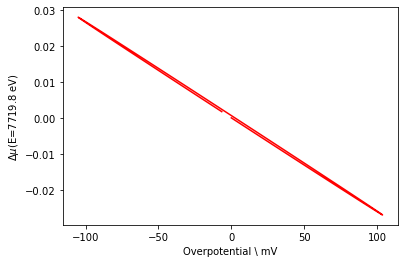

In [117]:
def sort_func(all_files):
    return int(all_files.split('\\E')[-1][:-4])

direc = r'E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_0.5Hz\\Txt Files\\'
freq_in = 0.5
ROhm = 29.5
step = 50
ang = -90
f_st = 88
f_end = 90

Ir_avgs_05 = []
models_Ir_05, models_Eta_05, models_V_05, models_J_05 = [], [], [], []
for E in range(f_st, f_end):
    ti, V, J, Ir, Io, If, Eta = [], [], [], [], [], [], []
    Ir_adj, J_adj, V_adj, Eta_adj = [], [], [], []
    Ir_adj_fit, J_adj_fit, V_adj_fit, Eta_adj_fit = [], [], [], []
    match_str = f'E{E}.txt'
    print(direc+match_str)
    ti, V, J, Ir, Io, If = time_domain.extract_data(direc, match_str,skip_head=0, sort_func=sort_func, end=2, xray_disp=False, xray_raw=True)
    ti = ti[::step]
    # Reversing V and J because the BioLogic SP-150 inverts these
    V = -V[::step]
    J = -J[::step]
    Ir = Ir[::step]
    Io = Io[::step]
    If = If[::step]
    print('Finished reading data')
    b = 0.1 * freq_in * (ti[-1]+ti[1])
    Eta = V - J * ROhm
    try:
        print('Phase align Ir')
        Ir_adj, Ir_adj_fit = time_domain.phase_align(ti, Eta, Ir, freq_in, b, phase=ang)
        print('Phase align J')
        J_adj, J_adj_fit = time_domain.phase_align(ti, Eta, J, freq_in, b, phase=ang)
        print('Phase align V')
        V_adj, V_adj_fit = time_domain.phase_align(ti, Eta, V, freq_in, b, phase=ang)
        print('Phase align Eta')
        Eta_adj, Eta_adj_fit = time_domain.phase_align(ti, Eta, Eta, freq_in, b, phase=ang)
        models_Ir_05.append(Ir_adj_fit)
        models_Eta_05.append(Eta_adj_fit)
        models_V_05.append(V_adj_fit)
        models_J_05.append(J_adj_fit)
        Z = (V_adj_fit.params['h1_re_comp'].value + 1j* V_adj_fit.params['h1_im_comp'].value) / (J_adj_fit.params['h1_re_comp'].value + 1j*J_adj_fit.params['h1_im_comp'].value)
        print(f' Z: {Z}')
        Ir_avgs_05.append(np.mean(If/Io))

    except:
        print(f'Analyzing E{E} unsuccessful')

Elist_fname = f'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\Dynamic XAS\\Energy List.txt'
energies = np.genfromtxt(Elist_fname)
energies = np.array([energies[i] for i in [f_st-1, f_end-2]])

print('Recontructing signals')
Irs_05, Etas_05, Vs_05, Ir_actual_05, Zs_05 = [], [], [], [], []
for model_Ir, model_Eta, model_V, model_J, Ir_avg in zip(models_Ir_05, models_Eta_05, models_V_05, models_J_05, Ir_avgs_05):
    Ns = int(model_Ir.ndata/2)
    dt = 1/(model_Ir.userkws['frequencies'][0]*-2)
    freq_in = model_Ir.userkws['freq_in']
    b = model_Ir.userkws['window_param']
    ti = np.linspace(0, dt*(Ns-1),num=Ns)
    Ns_wfm = int(1/freq_in/dt)
    
    Ir = fft.ifft(fft.ifftshift(model_Ir.eval()*(Ns*np.pi)))
    Eta = fft.ifft(fft.ifftshift(model_Eta.eval()*(Ns*np.pi)))
    V = fft.ifft(fft.ifftshift(model_V.eval()*(Ns*np.pi)))
    
    window = time_domain.gauss_window(np.ones(Ns), freq_in, ti, b)
    ti_05 = ti[:Ns_wfm]
    
    Irs_05.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Etas_05.append(Eta[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Vs_05.append(V[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Ir_actual_05.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm] + Ir_avg)
    
    Z = (model_V.params['h1_re_comp'].value + 1j * model_V.params['h1_im_comp'].value) / (model_J.params['h1_re_comp'].value + 1j * model_J.params['h1_im_comp'].value)
    Zs_05.append(Z)
Irs_05 = np.array(Irs_05)
Etas_05 = np.array(Etas_05)
Vs_05 = np.array(Vs_05)
Ir_actual_05 = np.array(Ir_actual_05)

fig = dxas.plot_lissajou(energies[:,None], Irs_05, Etas_05[0, :], plot_e=7719.8, start_ind=2, step=20, color=(1,0,0))

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_1Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (35.64474389113513-10.504970917898342j)
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_1Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (35.68146769181996-10.504695409607681j)
Recontructing signals
(50, 2) (-73.41315346150552+2.4659537723037767e-07j) (69.81139590091034+6.411730506810413e-08j)
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)


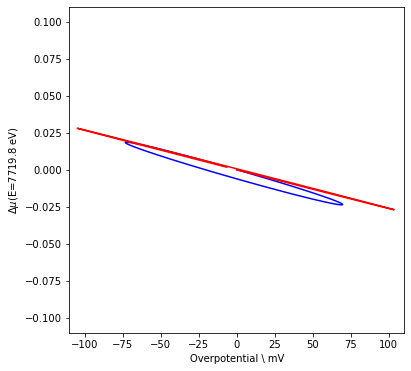

In [308]:
def sort_func(all_files):
    return int(all_files.split('\\E')[-1][:-4])

direc = r'E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_1Hz\\Txt Files\\'
freq_in = 1
ROhm = 33.5
step = 100
ang = -90

Ir_avgs_1 = []
models_Ir_1, models_Eta_1, models_V_1, models_J_1 = [], [], [], []
for E in range(f_st, f_end):
    ti, V, J, Ir, Io, If, Eta = [], [], [], [], [], [], []
    Ir_adj, J_adj, V_adj, Eta_adj = [], [], [], []
    Ir_adj_fit, J_adj_fit, V_adj_fit, Eta_adj_fit = [], [], [], []
    match_str = f'E{E}.txt'
    print(direc+match_str)
    ti, V, J, Ir, Io, If = time_domain.extract_data(direc, match_str,skip_head=0, sort_func=sort_func, end=2, xray_disp=False, xray_raw=True)
    ti = ti[::step]
    # Reversing V and J because the BioLogic SP-150 inverts these
    V = -V[::step]
    J = -J[::step]
    Ir = Ir[::step]
    Io = Io[::step]
    If = If[::step]
    print('Finished reading data')
    b = 0.1 * freq_in * (ti[-1]+ti[1])
    Eta = V - J * ROhm
    try:
        print('Phase align Ir')
        Ir_adj, Ir_adj_fit = time_domain.phase_align(ti, Eta, Ir, freq_in, b, phase=ang)
        print('Phase align J')
        J_adj, J_adj_fit = time_domain.phase_align(ti, Eta, J, freq_in, b, phase=ang)
        print('Phase align V')
        V_adj, V_adj_fit = time_domain.phase_align(ti, Eta, V, freq_in, b, phase=ang)
        print('Phase align Eta')
        Eta_adj, Eta_adj_fit = time_domain.phase_align(ti, Eta, Eta, freq_in, b, phase=ang)
        models_Ir_1.append(Ir_adj_fit)
        models_Eta_1.append(Eta_adj_fit)
        models_V_1.append(V_adj_fit)
        models_J_1.append(J_adj_fit)
        Z = (V_adj_fit.params['h1_re_comp'].value + 1j* V_adj_fit.params['h1_im_comp'].value) / (J_adj_fit.params['h1_re_comp'].value + 1j*J_adj_fit.params['h1_im_comp'].value)
        print(f' Z: {Z}')
        Ir_avgs_1.append(np.mean(If/Io))

    except:
        print(f'Analyzing E{E} unsuccessful')

Elist_fname = f'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\Dynamic XAS\\Energy List.txt'
energies = np.genfromtxt(Elist_fname)
energies = np.array([energies[i] for i in [f_st-1, f_end-2]])

print('Recontructing signals')
Irs_1, Etas_1, Vs_1, Ir_actual_1, Zs_1 = [], [], [], [], []
for model_Ir, model_Eta, model_V, model_J, Ir_avg in zip(models_Ir_1, models_Eta_1, models_V_1, models_J_1, Ir_avgs_1):
    Ns = int(model_Ir.ndata/2)
    dt = 1/(model_Ir.userkws['frequencies'][0]*-2)
    freq_in = model_Ir.userkws['freq_in']
    b = model_Ir.userkws['window_param']
    ti = np.linspace(0, dt*(Ns-1),num=Ns)
    Ns_wfm = int(1/freq_in/dt)
    
    Ir = fft.ifft(fft.ifftshift(model_Ir.eval()*(Ns*np.pi)))
    Eta = fft.ifft(fft.ifftshift(model_Eta.eval()*(Ns*np.pi)))
    V = fft.ifft(fft.ifftshift(model_V.eval()*(Ns*np.pi)))
    
    window = time_domain.gauss_window(np.ones(Ns), freq_in, ti, b)
    ti_1 = ti[:Ns_wfm]
    
    Irs_1.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Etas_1.append(Eta[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Vs_1.append(V[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
    Ir_actual_1.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm] + Ir_avg)
    
    Z = (model_V.params['h1_re_comp'].value + 1j * model_V.params['h1_im_comp'].value) / (model_J.params['h1_re_comp'].value + 1j * model_J.params['h1_im_comp'].value)
    Zs_1.append(Z)
Irs_1 = np.array(Irs_1)
Etas_1 = np.array(Etas_1)
Vs_1 = np.array(Vs_1)
Ir_actual_1 = np.array(Ir_actual_1)

fig = dxas.plot_lissajou(energies[:,None], Irs_1, Etas_1[0, :], plot_e=7719.8, start_ind=2, step=10, color=(0,0,1))
fig = dxas.plot_lissajou(energies[:,None], Irs_05, Etas_05[0, :], plot_e=7719.8, start_ind=2, step=20, color=(1,0,0), fig=fig)

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (57.8606831984842+10.332811263565203j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (57.81617676853747+10.29030979119497j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-44.43119147936445+2.007358635022331e-09j) (26.70530146587246+4.53670967508748e-10j)
57


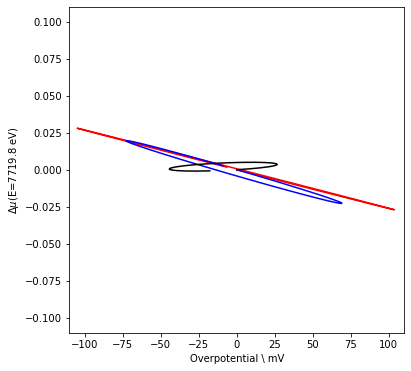

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.15458247345664+8.528651277447025j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.10799474896574+8.471397447073102j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-33.230680549626655+6.929482772831577e-16j) (25.815586729488764+3.5629660462479084e-16j)
57


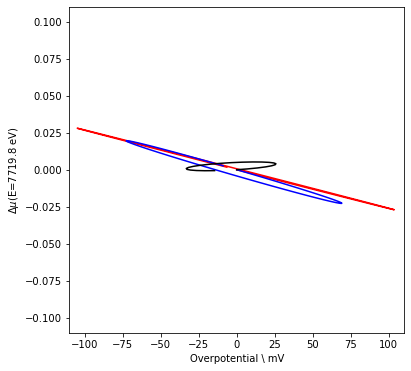

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.3942908385313+6.674679561285308j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.30209358654517+6.659154184834257j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-26.329107484266565+1.9187659088436243e-15j) (20.454010540857272+6.356173364301274e-16j)
57


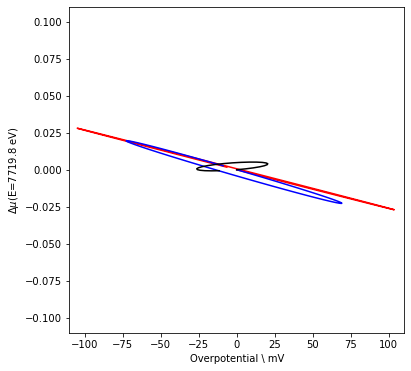

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.560404562088785+4.831502009340001j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.49888333259874+4.819256943370731j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-19.609667926222638+7.051517706636339e-16j) (15.23393930070302+1.0556530241736664e-15j)
57


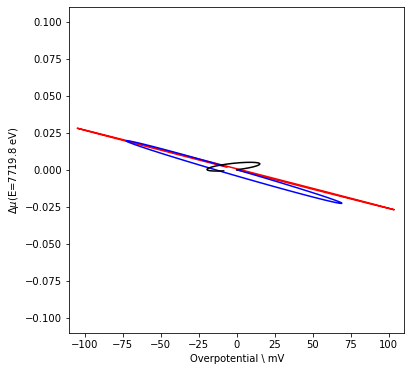

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.69669209326067+3.002459020018921j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.64891212365532+2.962963780348235j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-13.316666079595738+2.728219321063317e-16j) (10.345144118786322+3.051670695404711e-17j)
57


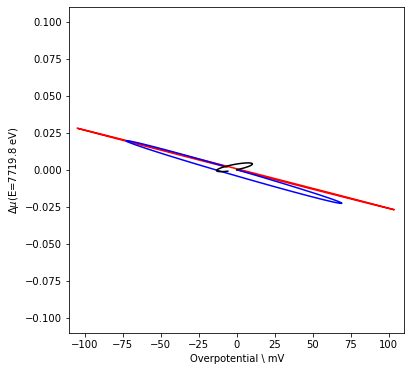

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.76299008268063+1.1756468266566473j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.711649194909484+1.1244379050857791j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-9.08058364668296+1.2259438570174785e-09j) (5.457885490215177+2.770659068079943e-10j)
57


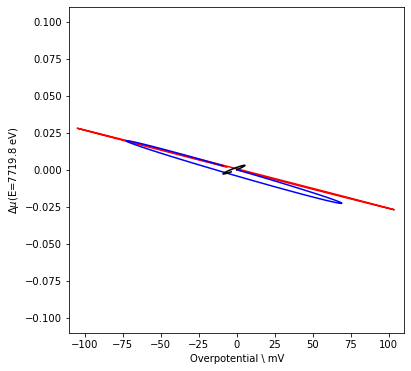

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.76979723983472-0.6940723838152725j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.67630471430591-0.6994171999959887j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-8.146515647278415+1.8190695761532675e-09j) (4.8964763816446855+4.111121798964519e-10j)
57


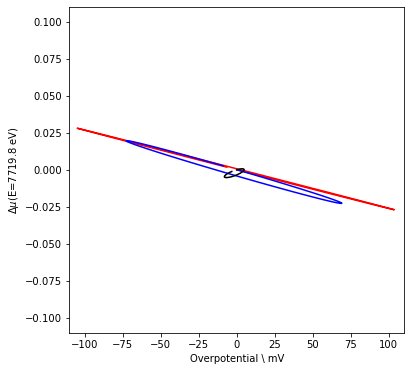

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.71093398146019-2.5269224415689355j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.6570634486527-2.555770890081824j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-13.079289892583738+8.826662121813676e-11j) (7.861278950070004+1.9950422109995703e-11j)
57


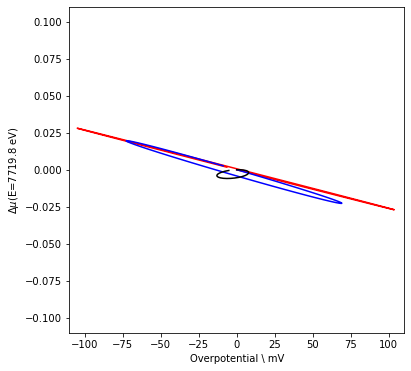

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.616495315507024-4.373948425957928j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.570006638094604-4.40793909836902j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-18.003977911873108+1.7362006573700316e-15j) (13.986595005787313+2.1606112684488282e-16j)
57


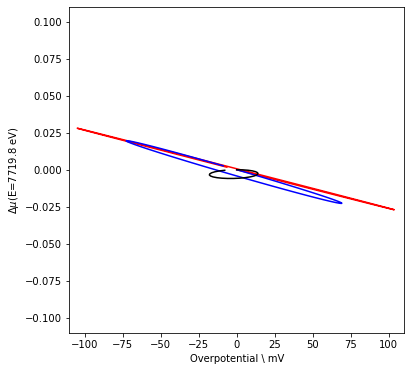

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.448899669829004-6.218910956871818j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.358884874412915-6.240164748706919j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-24.654249139647554+7.04243338040287e-16j) (19.152898298397268+3.0401856489369573e-15j)
57


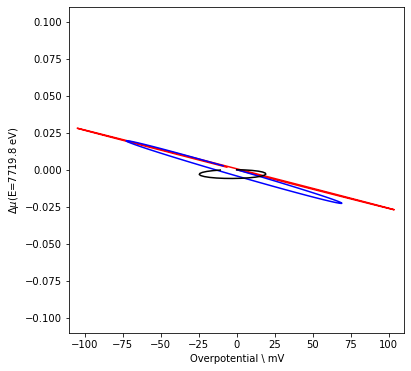

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.20776376822655-8.05578865194422j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (58.15882231730273-8.063703917765741j)
Save fits
Recontructing signals
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
(50, 2) (-72.80562052004099+2.452839084977962e-07j) (69.23366956069633+6.377630899792555e-08j)
(24, 2) (-31.45965978219673-6.282345365665314e-16j) (24.43976792834586-2.1728751669357065e-15j)
57


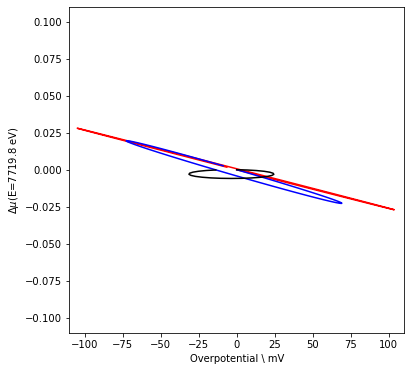

In [307]:
def sort_func(all_files):
    return int(all_files.split('\\E')[-1][:-4])

direc = r'E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\'
freq_in = 5
ROhm = 57
step = 200
ang = -90
f_st = 88
f_end = 90

for edge in np.arange(2.8, 3.01, .02): #64, 66, 68, 70, 72]:
    Ir_avgs_5 = []
    models_Ir_5, models_Eta_5, models_V_5, models_J_5 = [], [], [], []
    for E in range(f_st, f_end):
        ti, V, J, Ir, Io, If, Eta = [], [], [], [], [], [], []
        Ir_adj, J_adj, V_adj, Eta_adj = [], [], [], []
        Ir_adj_fit, J_adj_fit, V_adj_fit, Eta_adj_fit = [], [], [], []
        match_str = f'E{E}.txt'
        print(direc+match_str)
        ti, V, J, Ir, Io, If = time_domain.extract_data(direc, match_str,skip_head=0, sort_func=sort_func, end=2, xray_disp=False, xray_raw=True)
    #     ti = ti[::step]
        # Reversing V and J because the BioLogic SP-150 inverts these
        klu = int(edge/(freq_in*4)*5e4)
        V = -V[:-klu:step]
        J = -J[klu::step]
        Ir = Ir[:-klu:step]
        Io = Io[:-klu:step]
        If = If[:-klu:step]
        print('Finished reading data')
        b = 0.1 * freq_in * (ti[-1]+ti[1])
        Eta = V - J * ROhm
        try:
            print('Phase align Ir')
            Ir_adj, Ir_adj_fit = time_domain.phase_align(ti[:-klu:step], Eta, Ir, freq_in, b, phase=ang)
            print('Phase align J')
            J_adj, J_adj_fit = time_domain.phase_align(ti[klu::step] - ti[klu], Eta, J, freq_in, b, phase=ang)
            print('Phase align V')
            V_adj, V_adj_fit = time_domain.phase_align(ti[:-klu:step], Eta, V, freq_in, b, phase=ang)
            print('Phase align Eta')
            Eta_adj, Eta_adj_fit = time_domain.phase_align(ti[:-klu:step], Eta, Eta, freq_in, b, phase=ang)
            models_Ir_5.append(Ir_adj_fit)
            models_Eta_5.append(Eta_adj_fit)
            models_V_5.append(V_adj_fit)
            models_J_5.append(J_adj_fit)
            Z = (V_adj_fit.params['h1_re_comp'].value + 1j* V_adj_fit.params['h1_im_comp'].value) / (J_adj_fit.params['h1_re_comp'].value + 1j*J_adj_fit.params['h1_im_comp'].value)
            print(f' Z: {Z}')
            print('Save fits')
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_Ir', Ir_adj_fit)
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_J', J_adj_fit)
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_V', V_adj_fit)
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_Eta', Eta_adj_fit)
            Ir_avgs_5.append(np.mean(If/Io))

        except:
            print(f'Analyzing E{E} unsuccessful')

    Elist_fname = f'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\Dynamic XAS\\Energy List.txt'
    energies = np.genfromtxt(Elist_fname)
    energies = np.array([energies[i] for i in [f_st-1, f_end-2]])

    print('Recontructing signals')
    Irs_5, Etas_5, Vs_5, Ir_actual_5, Zs_5 = [], [], [], [], []
    for model_Ir, model_Eta, model_V, model_J, Ir_avg in zip(models_Ir_5, models_Eta_5, models_V_5, models_J_5, Ir_avgs_5):
        Ns = int(model_Ir.ndata/2)
        dt = 1/(model_Ir.userkws['frequencies'][0]*-2)
        freq_in = model_Ir.userkws['freq_in']
        b = model_Ir.userkws['window_param']
        ti = np.linspace(0, dt*(Ns-1),num=Ns)
        Ns_wfm = int(1/freq_in/dt)

        Ir = fft.ifft(fft.ifftshift(model_Ir.eval()*(Ns*np.pi)))
        Eta = fft.ifft(fft.ifftshift(model_Eta.eval()*(Ns*np.pi)))
        V = fft.ifft(fft.ifftshift(model_V.eval()*(Ns*np.pi)))

        window = time_domain.gauss_window(np.ones(Ns), freq_in, ti, b)
        ti_5 = ti[:Ns_wfm]

        Irs_5.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
        Etas_5.append(Eta[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
        Vs_5.append(V[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
        Ir_actual_5.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm] + Ir_avg)

        Z = (model_V.params['h1_re_comp'].value + 1j * model_V.params['h1_im_comp'].value) / (model_J.params['h1_re_comp'].value + 1j * model_J.params['h1_im_comp'].value)
        Zs_5.append(Z)
    Irs_5 = np.array(Irs_5)
    Etas_5 = np.array(Etas_5)
    Vs_5 = np.array(Vs_5)
    Ir_actual_5 = np.array(Ir_actual_5)

    fig = dxas.plot_lissajou(energies[:,None], Irs_05, Etas_05[0, :], plot_e=7719.8, start_ind=2, step=20, color=(1,0,0))
    fig = dxas.plot_lissajou(energies[:,None], Irs_1, Etas_1[0, :], plot_e=7719.8, start_ind=2, step=10, color=(0,0,1), fig=fig)
    fig = dxas.plot_lissajou(energies[:,None], Irs_5, Etas_5[0, :], plot_e=7719.8, start_ind=2, step=2, color=(0,0,0), fig=fig)

    fig.axes[0].set_xlim(-105*1.05, 105*1.05)
    fig.axes[0].set_ylim(-.105*1.05, .105*1.05)
    
    
    print(ROhm)
    plt.show()

In [243]:
Etas_5

array([[-0.15729472+1.11540614e-17j],
       [-0.15329487+7.01790487e-18j]])

In [244]:
V_adj_fit

In [245]:
J_adj_fit

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (-8.067838698915011-58.23296865896445j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (-8.044050579136938-58.16207111877165j)
Save fits
Recontructing signals
(24, 2) (-390.3244380565963-4.188904354750469e-09j) (234.60354166259046-9.466811766745319e-10j)
(50, 2) (-72.35514870808456+2.4397236269091914e-07j) (68.80529859858956+6.343529268526014e-08j)
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
62


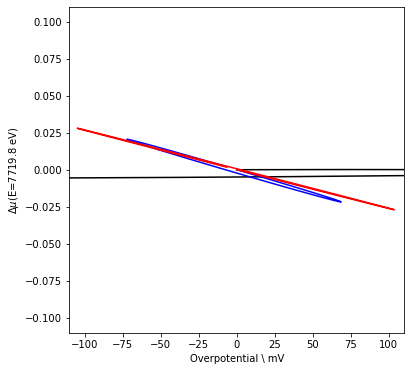

E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E88.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (-8.06783869891507-58.232968658964445j)
Save fits
E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\E89.txt
Finished reading data
Phase align Ir
Phase align J
Phase align V
Phase align Eta
 Z: (-8.044050579136984-58.16207111877164j)
Save fits
Recontructing signals
(24, 2) (-417.258721493346-4.520261102239074e-09j) (250.79232561225612-1.0215723647441695e-09j)
(50, 2) (-72.35514870808456+2.4397236269091914e-07j) (68.80529859858956+6.343529268526014e-08j)
(100, 2) (-105.03443500317208-3.8572754442963826e-08j) (103.72275699941981-9.660142269257177e-09j)
70


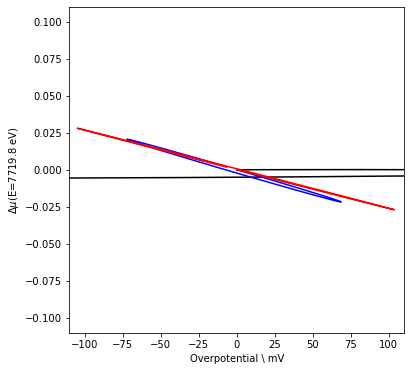

In [232]:
def sort_func(all_files):
    return int(all_files.split('\\E')[-1][:-4])

direc = r'E:\\UW Research\\fr-XAS Feb 2018\\Energy Spectrum_5Hz\\Txt Files\\'
freq_in = 5
ROhm = 65
step = 200
ang = -90
f_st = 88
f_end = 90

for ROhm in [62, 70]: #64, 66, 68, 70, 72]:
    Ir_avgs_5 = []
    models_Ir_5, models_Eta_5, models_V_5, models_J_5 = [], [], [], []
    for E in range(f_st, f_end):
        ti, V, J, Ir, Io, If, Eta = [], [], [], [], [], [], []
        Ir_adj, J_adj, V_adj, Eta_adj = [], [], [], []
        Ir_adj_fit, J_adj_fit, V_adj_fit, Eta_adj_fit = [], [], [], []
        match_str = f'E{E}.txt'
        print(direc+match_str)
        ti, V, J, Ir, Io, If = time_domain.extract_data(direc, match_str,skip_head=0, sort_func=sort_func, end=2, xray_disp=False, xray_raw=True)
        ti = ti[::step]
        # Reversing V and J because the BioLogic SP-150 inverts these
        klu = int(1/(freq_in*4)*5e4)
        V = -V[::step]
        J = -J[::step]
        Ir = Ir[::step]
        Io = Io[::step]
        If = If[::step]
        print('Finished reading data')
        b = 0.1 * freq_in * (ti[-1]+ti[1])
        Eta = V - J * ROhm
        try:
            print('Phase align Ir')
            Ir_adj, Ir_adj_fit = time_domain.phase_align(ti, Eta, Ir, freq_in, b, phase=ang)
            print('Phase align J')
            J_adj, J_adj_fit = time_domain.phase_align(ti, Eta, J, freq_in, b, phase=ang)
            print('Phase align V')
            V_adj, V_adj_fit = time_domain.phase_align(ti, Eta, V, freq_in, b, phase=ang)
            print('Phase align Eta')
            Eta_adj, Eta_adj_fit = time_domain.phase_align(ti, Eta, Eta, freq_in, b, phase=ang)
            models_Ir_5.append(Ir_adj_fit)
            models_Eta_5.append(Eta_adj_fit)
            models_V_5.append(V_adj_fit)
            models_J_5.append(J_adj_fit)
            Z = (V_adj_fit.params['h1_re_comp'].value + 1j* V_adj_fit.params['h1_im_comp'].value) / (J_adj_fit.params['h1_re_comp'].value + 1j*J_adj_fit.params['h1_im_comp'].value)
            print(f' Z: {Z}')
            print('Save fits')
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_Ir', Ir_adj_fit)
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_J', J_adj_fit)
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_V', V_adj_fit)
    #         hdf5_io.save_time_domain_fit(f'..\\Feb2018 Data Fits\\Energy Spectrum_5Hz\\Kludge_t_adjust\\{str(match_str[:-4])}_EtaAlign_Eta', Eta_adj_fit)
            Ir_avgs_5.append(np.mean(If/Io))

        except:
            print(f'Analyzing E{E} unsuccessful')

    Elist_fname = f'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\Xray-project\\Dynamic XAS\\Energy List.txt'
    energies = np.genfromtxt(Elist_fname)
    energies = np.array([energies[i] for i in [f_st-1, f_end-2]])

    print('Recontructing signals')
    Irs_5, Etas_5, Vs_5, Ir_actual_5, Zs_5 = [], [], [], [], []
    for model_Ir, model_Eta, model_V, model_J, Ir_avg in zip(models_Ir_5, models_Eta_5, models_V_5, models_J_5, Ir_avgs_5):
        Ns = int(model_Ir.ndata/2)
        dt = 1/(model_Ir.userkws['frequencies'][0]*-2)
        freq_in = model_Ir.userkws['freq_in']
        b = model_Ir.userkws['window_param']
        ti = np.linspace(0, dt*(Ns-1),num=Ns)
        Ns_wfm = int(1/freq_in/dt)

        Ir = fft.ifft(fft.ifftshift(model_Ir.eval()*(Ns*np.pi)))
        Eta = fft.ifft(fft.ifftshift(model_Eta.eval()*(Ns*np.pi)))
        V = fft.ifft(fft.ifftshift(model_V.eval()*(Ns*np.pi)))

        window = time_domain.gauss_window(np.ones(Ns), freq_in, ti, b)
        ti_5 = ti[:Ns_wfm]

        Irs_5.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
        Etas_5.append(Eta[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
        Vs_5.append(V[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm])
        Ir_actual_5.append(Ir[Ns_wfm:2*Ns_wfm]/window[Ns_wfm:2*Ns_wfm] + Ir_avg)

        Z = (model_V.params['h1_re_comp'].value + 1j * model_V.params['h1_im_comp'].value) / (model_J.params['h1_re_comp'].value + 1j * model_J.params['h1_im_comp'].value)
        Zs_5.append(Z)
    Irs_5 = np.array(Irs_5)
    Etas_5 = np.array(Etas_5)
    Vs_5 = np.array(Vs_5)
    Ir_actual_5 = np.array(Ir_actual_5)

    fig = dxas.plot_lissajou(energies[:,None], Irs_5, Etas_5[0, :], plot_e=7719.8, start_ind=2, step=2, color=(0,0,0))
    fig = dxas.plot_lissajou(energies[:,None], Irs_1, Etas_1[0, :], plot_e=7719.8, start_ind=2, step=10, color=(0,0,1), fig=fig)
    fig = dxas.plot_lissajou(energies[:,None], Irs_05, Etas_05[0, :], plot_e=7719.8, start_ind=2, step=20, color=(1,0,0), fig=fig)
    
    
    print(ROhm)
    plt.show()

In [233]:
V_adj_fit

In [196]:
tg = (570e-7)**2/(2.1*1.4e-6)
print(tg / (1/.5) * 360)
print(tg / (1/1) * 360)
print(tg / (1/5) * 360)

0.1989183673469388
0.3978367346938776
1.9891836734693877


In [39]:
for roh in np.linspace(20, 100):
    dume = V - J * roh
    print(f'Ohm: {roh:.2f} Min: {np.min(dume):.4f} Max: {np.max(dume):.4f}')

Ohm: 20.00 Min: -0.1393 Max: 0.1359
Ohm: 21.63 Min: -0.1345 Max: 0.1305
Ohm: 23.27 Min: -0.1296 Max: 0.1251
Ohm: 24.90 Min: -0.1247 Max: 0.1198
Ohm: 26.53 Min: -0.1198 Max: 0.1144
Ohm: 28.16 Min: -0.1150 Max: 0.1090
Ohm: 29.80 Min: -0.1101 Max: 0.1036
Ohm: 31.43 Min: -0.1052 Max: 0.0985
Ohm: 33.06 Min: -0.1004 Max: 0.0935
Ohm: 34.69 Min: -0.0955 Max: 0.0884
Ohm: 36.33 Min: -0.0906 Max: 0.0833
Ohm: 37.96 Min: -0.0857 Max: 0.0783
Ohm: 39.59 Min: -0.0809 Max: 0.0735
Ohm: 41.22 Min: -0.0760 Max: 0.0688
Ohm: 42.86 Min: -0.0711 Max: 0.0641
Ohm: 44.49 Min: -0.0664 Max: 0.0600
Ohm: 46.12 Min: -0.0620 Max: 0.0564
Ohm: 47.76 Min: -0.0577 Max: 0.0527
Ohm: 49.39 Min: -0.0534 Max: 0.0491
Ohm: 51.02 Min: -0.0494 Max: 0.0455
Ohm: 52.65 Min: -0.0457 Max: 0.0419
Ohm: 54.29 Min: -0.0426 Max: 0.0407
Ohm: 55.92 Min: -0.0402 Max: 0.0403
Ohm: 57.55 Min: -0.0378 Max: 0.0402
Ohm: 59.18 Min: -0.0364 Max: 0.0414
Ohm: 60.82 Min: -0.0378 Max: 0.0432
Ohm: 62.45 Min: -0.0423 Max: 0.0459
Ohm: 64.08 Min: -0.0470 Max:

In [ ]:
fig = dxas.plot_lissajou(energies[:,None], Irs_05, Etas_05[0, :], plot_e=7719.9, start_ind=2, step=20, color=(1,0,0))
fig = dxas.plot_lissajou(energies[:,None], Irs_1, Etas_1[0, :], plot_e=7719.9, start_ind=2, step=10, color=(0,0,1), fig=fig)
fig = dxas.plot_lissajou(energies[:,None], Irs_5, Etas_5[0, :], plot_e=7719.9, start_ind=2, step=2, color=(0,0,0), fig=fig)

(100, 2) (-110.29044988262322-4.02302845142567e-08j) (108.91313437011044-1.0075252726004228e-08j)
(50, 2) (-85.11093107035893+2.5839897308337284e-07j) (80.93525804012901+6.718635600474698e-08j)
(49, 2) (-29.597776935060388+1.4831223553817632e-15j) (26.10045566646403-1.043415398329347e-15j)


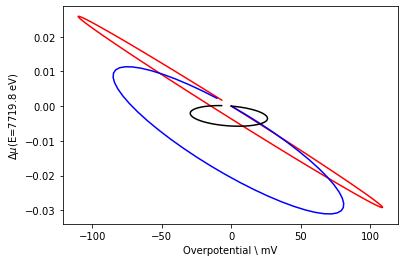

In [40]:
step = 20
fig = dxas.plot_lissajou(energies[:,None], Irs_05, Etas_05[0, :], plot_e=7719.8, start_ind=2, step=20, color=(1,0,0))
fig = dxas.plot_lissajou(energies[:,None], Irs_1, Etas_1[0, :], plot_e=7719.8, start_ind=2, step=10, color=(0,0,1), fig=fig)
fig = dxas.plot_lissajou(energies[:,None], Irs_5, Etas_5[0, :], plot_e=7719.8, start_ind=2, step=2, color=(0,0,0), fig=fig)
dum_ax = fig.axes[0]
# dum_ax.set_xlim(-.01, .01)
# plt.show()

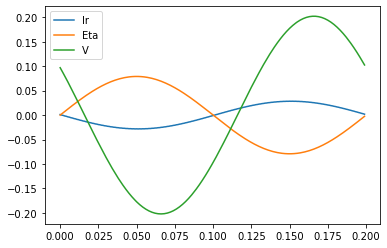

In [38]:
plt.plot(ti, (Irs[0]- np.mean(Irs[0]))*15, label='Ir')
plt.plot(ti, Etas[0], label='Eta')
plt.plot(ti, Vs[0], label='V')
plt.legend()

In [153]:
ls = ['-', '--', '-.', ':'] * 10

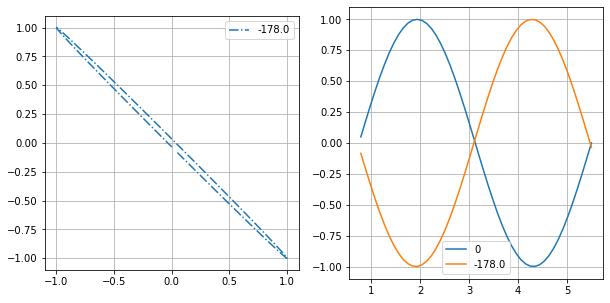

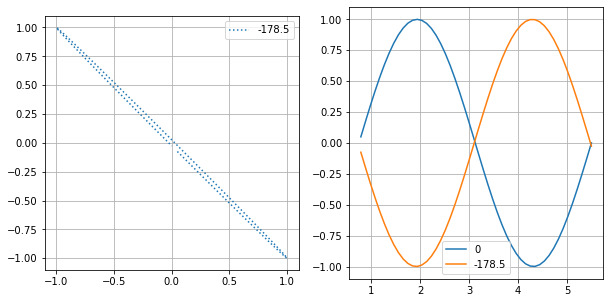

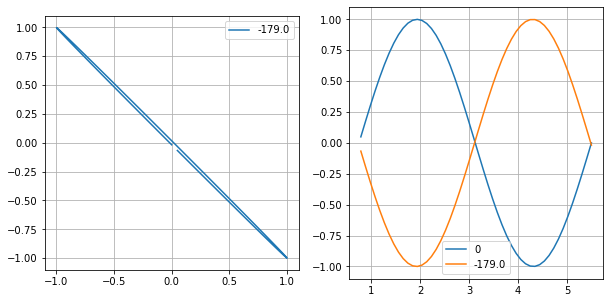

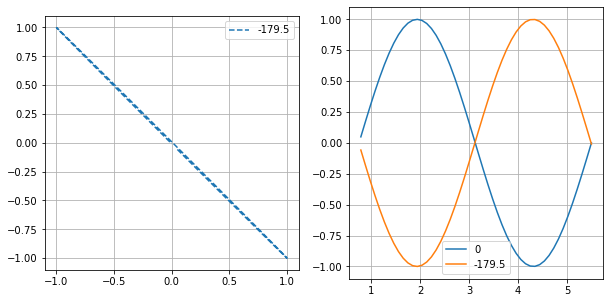

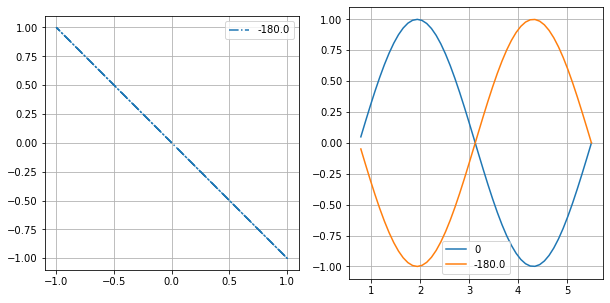

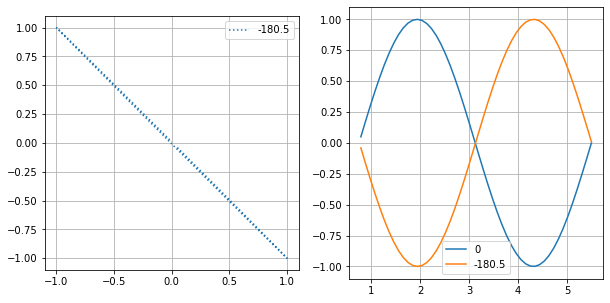

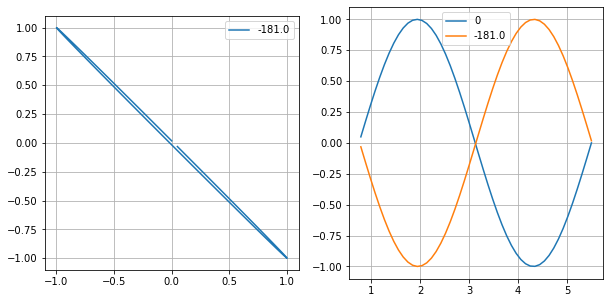

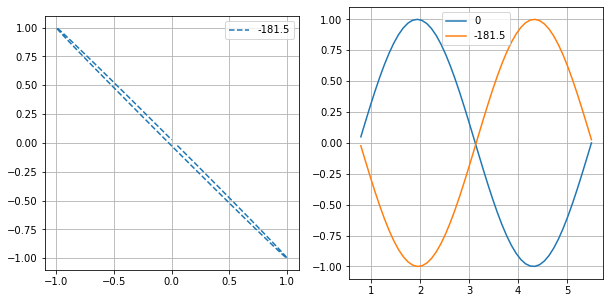

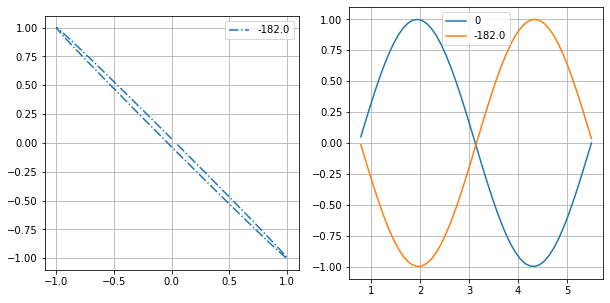

In [211]:
f = 1
theta = np.linspace(2*np.pi*(1/8), 2 * np.pi * (7/8))
t = np.linspace(2/256, 1)
w = 2 * np.pi * f

# y1 = .5 * (v1 * np.exp(1j * w * t ) + np.conj(v1) * np.exp(-1j * w * t))
# y2 = .5 * (v2 * np.exp(1j * w * t ) + np.conj(v2) * np.exp(-1j * w * t))

# for i, de in enumerate(np.arange(-160, -170, -4)):
#     _, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,5))
#     y1 = np.sin(theta)
#     y2 = np.sin(theta + de * np.pi/180)
    
#     ax1.plot(y1, y2, label=de, ls=ls[i+2])
    
#     ax2.plot(theta, y1, label='0')
#     ax2.plot(theta, y2, label=de)
#     ax1.set_aspect('equal')
#     ax1.grid()
#     ax2.grid()
#     ax1.legend()
#     ax2.legend()
#     plt.show()

for i, de in enumerate(np.arange(-178, -182.5, -.5)):
    _, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,5))
    th0 = -np.pi/2
    v1 = (np.cos(th0) + 1j*np.sin(th0))
    v2 = (np.cos(th0 + de * np.pi/180) + 1j*np.sin(th0 + de * np.pi/180))
    y1 = .5 * (v1 * np.exp(1j * w * t ) + np.conj(v1) * np.exp(-1j * w * t))
    y2 = .5 * (v2 * np.exp(1j * w * t ) + np.conj(v2) * np.exp(-1j * w * t))
    
    ax1.plot(y1, y2, label=de, ls=ls[i+2])
    
    ax2.plot(theta, y1, label='0')
    ax2.plot(theta, y2, label=de)
    ax1.set_aspect('equal')
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend()
    plt.show()
# ax.plot(t, y1, 'k-', label='y1')
# ax.plot(t, y2, 'r:', label='y2')

# ax.plot([0, 0], [-2, 2], 'k-')
# ax.plot([-2, 2], [0, 0])
